In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Scenario

TheLook, a hypothetical eCommerce clothing retailer, stores data on customers, products, orders, logistics, web events, and digital marketing campaigns in BigQuery. The company wants to leverage the team's existing SQL and PySpark expertise to analyze this data using Apache Spark.

To avoid manual infrastructure provisioning or tuning for Spark, TheLook seeks an auto-scaling solution that allows them to focus on workloads rather than cluster management. Additionally, they want to minimize the effort required to integrate Spark and BigQuery while staying within the BigQuery Studio environment, possibly using BigQuery notebooks.

They then want to productionalize the model by having a queryable endpoint, and a way to query it via natural language.

Let's understand how they can perform following analysis using Apache Spark:


# Goal

Predict whether a user will make a purchase by building a Logistic Regression Classifier using PySpark and leverage BQ Studio's native Integration and AI-features for exploring the data.


# **Step 1: Upload the notebook to BigQuery**

Follow **Step 1** in the Qwiklab to upload the notebook to BigQuery Studio.



# **Step 2: Connect to a runtime**

Click **Connect** to connect to a runtime.

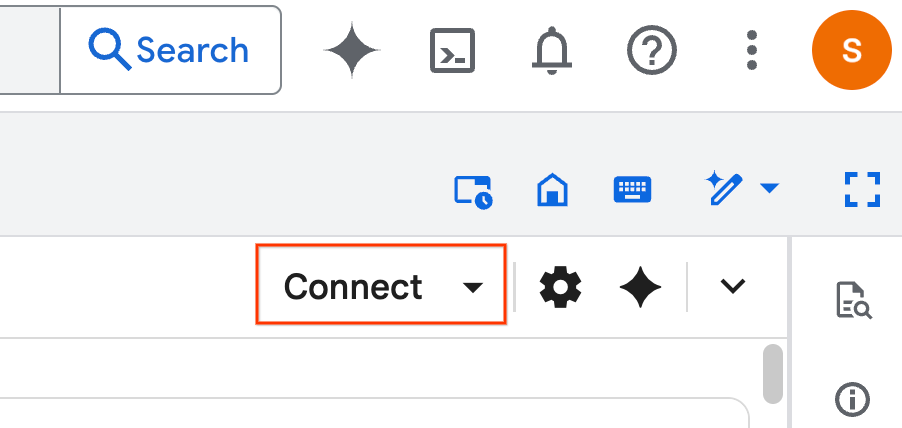

# **Step 3: Setup**

The following steps create resources that will be used throughout the tutorial.

Enable necessary APIs and then **refresh the page**.

In [ ]:
import subprocess

command = [
    "gcloud",
    "services",
    "enable",
    "aiplatform.googleapis.com",
    "bigquery.googleapis.com",
    "bigquerystorage.googleapis.com",
    "bigqueryunified.googleapis.com",
    "cloudaicompanion.googleapis.com",
    "dataproc.googleapis.com",
    "run.googleapis.com",
    "storage.googleapis.com"
]

result = subprocess.run(command, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

Configure a project id and location.

In [ ]:
PROJECT_ID = "" # @param {type:"string"}

REGION = "us-central1" # @param {type:"string"}

To use [Google Cloud Serverless for Apache Spark](https://docs.cloud.google.com/dataproc-serverless/docs), turn on [Private Google Access](https://docs.cloud.google.com/vpc/docs/configure-private-google-access#gcloud_1).

In [ ]:
import subprocess

command = [
    "gcloud",
    "compute",
    "networks",
    "subnets",
    "update",
    "default",
    f"--region={REGION}",
    "--enable-private-ip-google-access"
]

result = subprocess.run(command, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

Create a [Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets?utm_campaign=CDR_0x225cfd13_default_b407565440&utm_source=external&utm_medium=web).


In [ ]:
from google.cloud import storage
from google.cloud.exceptions import NotFound

BUCKET_NAME = f"{PROJECT_ID}-demo"

storage_client = storage.Client(project=PROJECT_ID)
try:
    bucket = storage_client.get_bucket(BUCKET_NAME)
    print(f"Bucket {BUCKET_NAME} already exists.")
except NotFound:
    bucket = storage_client.create_bucket(BUCKET_NAME, location=REGION)
    print(f"Bucket {BUCKET_NAME} created.")

Create a BigQuery dataset.

In [ ]:
from google.cloud import bigquery

DATASET_ID = f"{PROJECT_ID}.demo"

client = bigquery.Client()

dataset = bigquery.Dataset(DATASET_ID)

dataset.location = REGION

dataset = client.create_dataset(dataset, exists_ok=True)

# **Step 4: Create a connection to Google Cloud Serverless for Apache Spark**

Set up the Spark environment: It imports necessary libraries for connecting to Dataproc and using PySpark. Configure the Dataproc session: It creates and configures a Spark Session with the necessary parameters, providing the spark object for subsequent Spark operations.

This step can also be accomplished in a single line of code below.

```
spark = DataprocSparkSession.builder.getOrCreate()
```


Create the `Session()` object to definite parameters. Here, you set the runtime version to `3.0` and cap the number of executors (Spark workers)to `4`.

In [ ]:
from google.cloud.dataproc_spark_connect import DataprocSparkSession
from google.cloud.dataproc_v1 import Session

session = Session()

session.runtime_config.version = "3.0"

# To avoid going over quota in this demo, cap the max number of Spark workers.
session.runtime_config.properties = {
    "spark.dynamicAllocation.maxExecutors": "4"
}

For large workloads, you can use [Lightning Engine](https://cloud.google.com/products/lightning-engine) to further accelerate your Spark workloads by up to [4.3x](https://docs.cloud.google.com/dataproc-serverless/docs/guides/lightning-engine#enable_lightning_engine). The dataset in this lab is too small to see meaningful differences, but you can try it on your own data by setting the following properties:

```
session.runtime_config.properties = {
  "dataproc.runtime": "premium",
  "spark.dataproc.engine": "lightningEngine",
}


Create the Spark Session.

**Notes:**
1. The first time you run this cell, you may encounter a service account error. Wait about 60 seconds and try again.

2. You may be asked to authenticate. Click the link in the output to do so.

In [ ]:
spark = (
    DataprocSparkSession.builder
      .appName("CustomSparkSession")
      .dataprocSessionConfig(session)
      .getOrCreate()
)

# **Step 5: Load data and explore with Gemini**

The serverless Spark runtime is configured to load your data directly from BigQuery into a Spark dataframe.

Load a dataset of user data.

In [ ]:
users = spark.read.format("bigquery").option("table", "bigquery-public-data.thelook_ecommerce.users").load()
users.show()

Load a dataset or orders data.

In [ ]:
order_items = spark.read.format("bigquery").option("table", "bigquery-public-data.thelook_ecommerce.order_items").load()
order_items.show()

Register these tables as Spark SQL tables.

In [ ]:
users.createOrReplaceTempView("users")
order_items.createOrReplaceTempView("order_items")

Use SparkSQL to query a table directly. Query the `users` table.

In [ ]:
spark.sql("SELECT * FROM users LIMIT 10").show()

Query the `order_items` table.

In [ ]:
spark.sql("SELECT * FROM order_items LIMIT 10").show()

Bigquery Studio can leverage Gemini for [advanced code completion capabilities](https://cloud.google.com/bigquery/docs/write-sql-gemini#generate_python_code?utm_campaign=CDR_0x225cfd13_default_b407565440&utm_source=external&utm_medium=web) which can use Natual Language to perform exploratory analysis using SQL and even generate PySpark Code for Feature Engineering.

Try the following examples. For each prompt, create a new **Code** cell and click **Generate** to generate the code.


**Prompt 1**: Using PySpark, explore the users table and show the first 10 rows.

**Prompt 2**: Using PySpark, explore the order_items table and show the first 10 rows.

**Prompt 3**: Using PySpark, show the top 5 most frequent countries in the users table. Display the country and the number of users from each country.

**Prompt 4**: Using PySpark, find the average sale price of items in the order_items table.

**Prompt 5**: Using the table "users", generate code to plot country vs traffic source using a suitable plotting library.

**Prompt 6:** Create a histogram showing the distribution of "age", "country", "gender", "traffic_source".

## **Step 6: Feature engineering**

In this step, we derive two key columns from the input data:

**Creation of features column**:
It combines user attributes (age, hashed categorical features) into a numerical array, preparing them for a machine learning model.

**Generation of label column:**
It creates a binary target variable indicating whether a user has made a purchase or not, derived from order information.

In [ ]:
features = spark.sql("""
SELECT
  CAST(u.age AS DOUBLE) AS age,
  CAST(hash(u.country) AS BIGINT) * 1.0 AS country_hash,
  CAST(hash(u.gender) AS BIGINT) * 1.0 AS gender_hash,
  CAST(hash(u.traffic_source) AS BIGINT) * 1.0 AS traffic_source_hash,
  CASE WHEN COUNT(oi.id) > 0 THEN 1 ELSE 0 END AS label -- Changed label generation to count order items
FROM users AS u
LEFT JOIN order_items AS oi
ON u.id = oi.user_id
GROUP BY u.id, u.age, u.country, u.gender, u.traffic_source
""")
features.show()

# **Step 7: Train a logistic regression model**

This code trains a logistic regression model to predict user purchase behavior, with these steps:

**Vector Assembly:** VectorAssembler formats the data into readable vectors.

**Feature Scaling:** StandardScaler scales the "features" column.

**Model Initialization:** LogisticRegression is set up to predict the binary "label" (purchase/no purchase), with hyperparameters for training.

**Pipeline Definition:** A Pipeline chains StandardScaler and LogisticRegression for streamlined scaling and training.

**Model Training:** `pipeline.fit(dataset)` trains the pipeline (scaling and then the model).

**Prediction:** `pipeline_model.transform(dataset)` generates predictions, and `transformed_dataset.show()` displays the results.

In short, this step scales features, trains a logistic regression model within a pipeline, and produces purchase predictions.

In [ ]:
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.functions import array_to_vector

#Split Train and Test Data (80:20)
train_data, test_data = features.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Initialize VectorAssembler
assembler = VectorAssembler(
    inputCols=["age", "country_hash", "gender_hash", "traffic_source_hash"],
    outputCol="assembled_features"
)

# Initialize StandardScaler
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Initialize Logistic Regression model
lr = LogisticRegression(
    maxIter=100,
    regParam=0.2,
    threshold=0.8,
    featuresCol="scaled_features",
    labelCol="label"
)

# Define pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Fit the model
pipeline_model = pipeline.fit(train_data)

# Transform the dataset using the trained model
transformed_dataset = pipeline_model.transform(test_data)

In [ ]:
transformed_dataset.show()

# **Step 8: Model evaluation**

This code evaluates the trained model's performance by:

**Initializing an Evaluator:** A BinaryClassificationEvaluator is set up to calculate the Area Under the Precision-Recall Curve (AUC-PR).

**Calculating AUC-PR:** The evaluate() method calculates the AUC-PR score using the model's predictions.

This step quantifies the model's ability to distinguish between the two classes (e.g., purchase/no purchase).

In [ ]:
# Model evaluation
eva = BinaryClassificationEvaluator(metricName="areaUnderPR")
aucPR = eva.evaluate(transformed_dataset)
print(f"AUC PR: {aucPR}")


Use Gemini to generate code to visualize the output.

**Prompt 1:** Generate code to plot the Precision-Recall (PR) curve. Calculate precision and recall from the model's predictions and display the PR curve using a suitable plotting library.

**Prompt 2:** Generate code to create a confusion matrix visualization. Calculate the confusion matrix from the model's predictions and display it as a heatmap or a table with counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).

# **Step 9: Write predictions to BigQuery**

Use Gemini to write predictions to BigQuery.

**Prompt:** Using Spark, write the transformed dataset to BigQuery.

# **Step 10: Save model to Cloud Storage**

Save your MLlib model to Cloud Storage.

In [ ]:
GCS_MODEL_PATH="models/prediction_model"
pipeline_model.write().overwrite().save(f"gs://{BUCKET_NAME}/{GCS_MODEL_PATH}")

# **Step 11: Create an inference server**

Use [Cloud Run](https://cloud.google.com/run) to create an inference server for your MLlib model.

Clone the Github Repository [devrel-demos](https://github.com/GoogleCloudPlatform/devrel-demos).

In [ ]:
!git clone https://github.com/GoogleCloudPlatform/devrel-demos.git

Deploy the Cloud Run server. This can take up to ten minutes - make sure to keep the notebook open until this cell finishes running.

In [ ]:
import subprocess

command = [
    "gcloud",
    "run",
    "deploy",
    "inference-server",
    "--source",
    "/content/devrel-demos/data-analytics/dataproc-webinar/data-science/inference-server",
    "--region",
    f"{REGION}",
    "--port",
    "8080",
    "--memory",
    "2Gi",
    "--allow-unauthenticated",
    "--set-env-vars",
    f"GCS_BUCKET={BUCKET_NAME},GCS_MODEL_PATH={GCS_MODEL_PATH}",
    "--startup-probe",
    "tcpSocket.port=8080,initialDelaySeconds=240,failureThreshold=3,timeoutSeconds=240,periodSeconds=240"
]

result = subprocess.run(command, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

Copy the Service URL from the output and paste it below.

In [ ]:
INFERENCE_SERVER_URL = "" #@param {type:"string"}

Test your inference server.

In [ ]:
import requests

age = "25.0"
country = "United States"
traffic_source = "Search"
gender = "F"

response = requests.post(
    f"{INFERENCE_SERVER_URL}/predict",
    json=[{"age": age, "country": country, "traffic_source": traffic_source, "gender": gender}],
    headers={"Content-Type": "application/json"}
)

print(response.json())

# **Step 12: Create a remote agent**

[Vertex AI Agent Engine](https://docs.cloud.google.com/agent-builder/agent-engine/overview) is a service for deploying, managing, and scaling AI agents in production.

The [Agent Development Kit (ADK)](https://google.github.io/adk-docs/) is a model-agnostic framework for developing and deploying AI Agents.

Use these two to build an agent that can call the deployed SparkML model


Initialize a Vertex AI Client.

In [ ]:
import vertexai
from vertexai import agent_engines # For the prebuilt templates

client = vertexai.Client(  # For service interactions via client.agent_engines
    project=f"{PROJECT_ID}",
    location=f"{REGION}",
)

Define a function for querying the deployed model.

In [ ]:
def predict_purchase(
    age: str = "25.0",
    country: str = "United States",
    traffic_source: str = "Search",
    gender: str = "M",
):
    """Predicts whether or not a user will purchase a product.

    Args:
        age: The age of the user.
        country: The country of the user. One of: "China", "Poland", "Germany", "United States", "Spain", "United Kingdom", "España", "Japan", "Brasil", "Colombia", "Belgium", "South Korea", "Austria", "France", "Australia".
        Traffic_source: The source of the user's traffic. One of: "Display", "Email", "Search", "Organic", "Facebook".
        gender: The gender of the user. One of: "M" or "F".

    Returns:
        True if the model output is 1.0, False otherwise.
    """
    import requests
    response = requests.post(
        f"{INFERENCE_SERVER_URL}/predict",
        json=[{"age": age, "country": country, "traffic_source": traffic_source, "gender": gender}],
        headers={"Content-Type": "application/json"}
    )
    return response.json()

Test the function by passing in sample parameters.

In [ ]:
predict_purchase(age=25.0, country="United States", traffic_source="Search", gender="M")

Using the ADK, define an agent below and provide the `predict_purchase` function as a tool.

In [ ]:
from google.adk.agents import Agent
from vertexai import agent_engines

agent = Agent(
   model="gemini-2.5-flash",
   name='purchase_prediction_agent',
   tools=[predict_purchase]
)

Test the agent locally by passing in a query.

In [ ]:
app = agent_engines.AdkApp(agent=agent)
async for event in app.async_stream_query(
    user_id="123",
    message="Will a 25 yo male from the United States who came from Search make a purchase? Strictly output 'yes' or 'no'.",
):
    try:
        print(event['content']['parts'][0]['text'])
    except:
      continue

Deploy the model to Agent Engine.

In [ ]:
remote_agent = client.agent_engines.create(
    agent=app,
    config={
        "requirements": ["google-cloud-aiplatform[agent_engines,adk]"],
        "staging_bucket": f"gs://{BUCKET_NAME}",
        "display_name": "purchase-predictor",
        "description": "Agent that predicts whether or not a user will purchase a product.",
    }
)

Once done, view the deployed model in the [Cloud Console](https://console.cloud.google.com/vertex-ai/agents/agent-engines).

Query the model again. This now point to the deployed agent instead of the local version.

In [ ]:
async for event in remote_agent.async_stream_query(
    user_id="123",
    message="Will a 25 yo male from the United States who came from Search make a purchase? Strictly output 'yes' or 'no'.",
):
    try:
        print(event['content']['parts'][0]['text'])
    except:
      continue

# **Step 13: Clean up**

Delete the deployed agent.

In [ ]:
remote_agent.delete(force=True)

Delete the inference server.

In [ ]:
import subprocess

command = [
    "gcloud",
    "run",
    "services",
    "delete",
    "inference-server",
    "--region",
    f"{REGION}",
    "--quiet"
]

subprocess.run(command, capture_output=True, text=True)

Delete the BigQuery dataset.

In [ ]:
bigquery_client = bigquery.Client()

bigquery_client.delete_dataset(
    f"{PROJECT_ID}.demo", delete_contents=True, not_found_ok=True
)

Delete the Storage bucket.

In [ ]:
storage_client = storage.Client()

bucket = storage_client.get_bucket(BUCKET_NAME)
bucket.delete_blobs(list(bucket.list_blobs()))
bucket.delete()